In [1]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from scipy.optimize import fmin_l_bfgs_b

CONTENT_PATH = '/content/drive/MyDrive/deep learning lanjut/gambar/raja-ampat.jpg'
STYLE_PATH = '/content/drive/MyDrive/deep learning lanjut/gambar/penjaga-malam.jpg'
OUTPUT_IMAGE_PATH = '/content/output_style_transfer.png'

CONTENT_WEIGHT = 2.5e-2
STYLE_WEIGHT = 1.0
TOTAL_VARIATION_WEIGHT = 1e-6
ITERATIONS = 50
IMG_SIZE = 512


In [2]:
def preprocess_image(path, target_size=(800, 450)):   # <-- ukuran baru di sini
    img = Image.open(path).convert("RGB")
    img = img.resize(target_size)                      # <-- resize langsung rasio 16:9
    x = np.expand_dims(np.array(img, dtype='float32'), axis=0)
    return vgg19.preprocess_input(x)

def deprocess_image(x):
    x = x.copy()
    if x.ndim == 4: x = x[0]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    return Image.fromarray(np.clip(x, 0, 255).astype('uint8'))

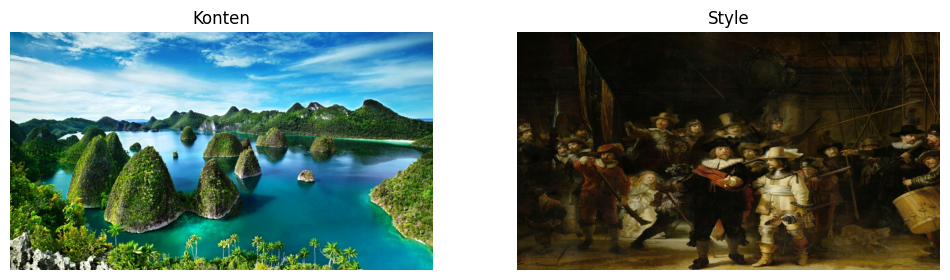

In [3]:
content_img = Image.open(CONTENT_PATH).resize((800, 450))
style_img = Image.open(STYLE_PATH).resize((800, 450))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title("Konten")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title("Style")
plt.axis('off')
plt.show()


In [4]:
def content_loss(base, target):
    return tf.reduce_sum(tf.square(target - base))

def gram_matrix(x):
    x = tf.squeeze(x, axis=0)
    channels = x.shape[-1]
    size = tf.shape(x)[0] * tf.shape(x)[1]
    x = tf.reshape(x, (size, channels))
    return tf.matmul(x, x, transpose_a=True)

def style_loss(base, target):
    S, C = gram_matrix(base), gram_matrix(target)
    channels = tf.cast(base.shape[-1], tf.float32)
    size = tf.cast(base.shape[1]*base.shape[2], tf.float32)
    return tf.reduce_sum(tf.square(S - C)) / (4*(channels**2)*(size**2))

def total_variation_loss(x):
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a+b, 1.25))


In [5]:
CONTENT_LAYER = 'block5_conv2'
STYLE_LAYERS = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs_dict = {l.name: l.output for l in vgg.layers if l.name in STYLE_LAYERS + [CONTENT_LAYER]}
    return tf.keras.Model(vgg.input, list(outputs_dict.values())), outputs_dict

content_array = preprocess_image(CONTENT_PATH)
style_array = preprocess_image(STYLE_PATH, target_size=content_array.shape[1:3])

model, outputs_dict = get_model()
content_features = dict(zip(outputs_dict.keys(), model(tf.constant(content_array))))
style_features = dict(zip(outputs_dict.keys(), model(tf.constant(style_array))))


In [6]:
comb_image = tf.Variable(content_array, dtype=tf.float32)

@tf.function
def compute_loss_and_grads(model, content_features, style_features, img):
    with tf.GradientTape() as tape:
        tape.watch(img)
        outputs = model(img)
        feat_outputs = dict(zip(outputs_dict.keys(), outputs))

        c_loss = content_loss(content_features[CONTENT_LAYER], feat_outputs[CONTENT_LAYER])
        s_loss = tf.add_n([style_loss(style_features[l], feat_outputs[l]) for l in STYLE_LAYERS])
        tv_loss = total_variation_loss(img)
        total = CONTENT_WEIGHT*c_loss + STYLE_WEIGHT*s_loss + TOTAL_VARIATION_WEIGHT*tv_loss
    grads = tape.gradient(total, img)
    return total, grads

class LBFGSHelper:
    def __init__(self, model, c_feat, s_feat):
        self.model = model
        self.c_feat = c_feat
        self.s_feat = s_feat
        self._loss_val = None
        self._grad_val = None
        self._img_shape = None

    def set_shape(self, shape):
        self._img_shape = shape

    def loss(self, x):
        x = x.astype('float32').reshape(1,*self._img_shape)
        loss_val, grad_val = compute_loss_and_grads(self.model, self.c_feat, self.s_feat, tf.constant(x))
        self._loss_val = loss_val.numpy()
        self._grad_val = grad_val.numpy().flatten().astype('float64')
        return self._loss_val

    def grads(self, x):
        return self._grad_val

helper = LBFGSHelper(model, content_features, style_features)
helper.set_shape(content_array.shape[1:])

x_flat = comb_image.numpy().flatten().astype('float64')

for i in range(ITERATIONS):
    x, min_val, info = fmin_l_bfgs_b(helper.loss, x_flat, fprime=helper.grads, maxfun=20)
    x_flat = x
    comb_image.assign(tf.constant(x.reshape(1,*content_array.shape[1:]), dtype=tf.float32))

    if (i+1) % 10 == 0:
        tmp_img = deprocess_image(comb_image.numpy())
        tmp_img.save(f"/content/temp_output_iter_{i+1}.png")
        print(f"Iterasi {i+1} loss: {min_val:.2f} -> gambar sementara disimpan")


Iterasi 10 loss: 120593800.00 -> gambar sementara disimpan
Iterasi 20 loss: 77811312.00 -> gambar sementara disimpan
Iterasi 30 loss: 61182880.00 -> gambar sementara disimpan
Iterasi 40 loss: 53836688.00 -> gambar sementara disimpan
Iterasi 50 loss: 48806656.00 -> gambar sementara disimpan


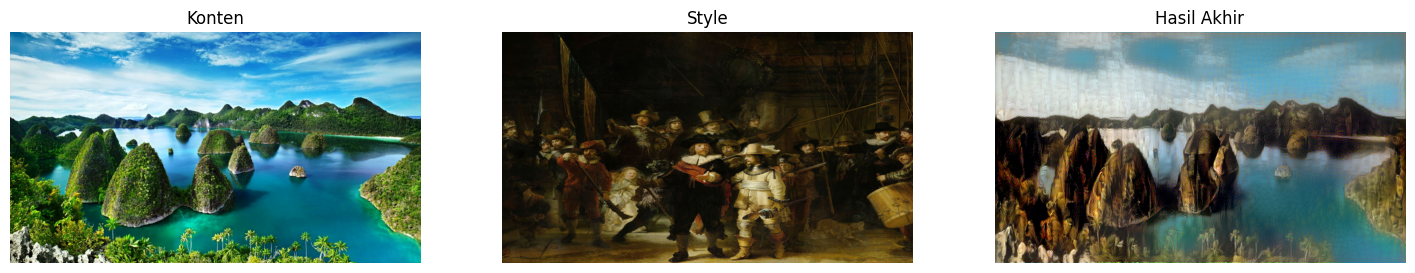

In [7]:
final_img = deprocess_image(comb_image.numpy())
final_img.save(OUTPUT_IMAGE_PATH)

original_content = Image.open(CONTENT_PATH).resize(final_img.size)
original_style = Image.open(STYLE_PATH).resize(final_img.size)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
axes[0].imshow(original_content); axes[0].set_title("Konten"); axes[0].axis('off')
axes[1].imshow(original_style); axes[1].set_title("Style"); axes[1].axis('off')
axes[2].imshow(final_img); axes[2].set_title("Hasil Akhir"); axes[2].axis('off')
plt.show()
